# Introduction to Sentiment Classification techniques with scikit-learn, keras and tensorflow

### Motivation and project description

Text information is everywhere: in social media, user reviews or open forums, news, e-mail, etc. In today's context, many Natural Langage Processing techniques are here to help you extract the value from all this textual information and can lead to many exciting use cases:
Predict a stock price movement with a sentiment index based on twitter data,
Understand the pain points of customer during their journeys thanks to social media or forums,
Etc.

The goal of the project is to classify financial news headlines according to three sentiment levels: negative, neutral, positive. Such a classifier could be very helpful if you want to build a sentiment index based on news for a given sector for example. I focused my work on trying to answer the following questions:
- What are the financial headlines I should pay attention to in terms of their very positive or negative tone?
- To what extent can I trust such a classifier?

### Selection of an Data Set to implement sentiment classification techniques

After searching for some text classification Open Data Sets detailed below, I finaly chose a [data set available on Kaggle (https://www.kaggle.com/ankurzing/sentiment-analysis-for-financial-news)

- [Open Data Sets for text classification](https://medium.com/@dataturks/rare-text-classification-open-datasets-9d340c8c508e)

- [IMBD DataSet for Movies Reviews](http://ai.stanford.edu/~amaas/data/sentiment/)

- [BBC text categorization](https://www.kaggle.com/yufengdev/bbc-text-categorization)

- [Sentiment Analysis in Finance](https://www.kaggle.com/ankurzing/sentiment-analysis-for-financial-news)

### Usefull links when writing this medium post:
- Links on medium posts best practices :
    - [Get Started with medium](https://blog.hubspot.com/marketing/how-to-use-medium)
    - [Tips for medium writer](https://blog.medium.com/tips-and-tricks-for-medium-writers-1d79498101c3)
- Links on Data Science posts regarding text classification techniques :
    - https://towardsdatascience.com/basic-binary-sentiment-analysis-using-nltk-c94ba17ae386
    - https://medium.com/analytics-vidhya/how-to-succeed-in-multilingual-sentiment-analysis-without-transformers-f1a98c76c30c
    - https://towardsdatascience.com/text-classification-with-extremely-small-datasets-333d322caee2

### Import Usefull Packages

In [1]:
# Classic Python Package
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

In [2]:
from wordcloud import WordCloud,STOPWORDS

In [3]:
# Text feature engineering related packages
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

from nltk.corpus import stopwords,wordnet
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import re

[nltk_data] Downloading package punkt to /Users/boubou/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/boubou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/boubou/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/boubou/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [4]:
# Scikit learn useful packages
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report,fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV, train_test_split,StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix,confusion_matrix

In [5]:
# Import Deep Learning packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense,Dropout,Input,LSTM,Embedding,Activation
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.utils import to_categorical

# I. Data Exploration of the financial news headlines, and first feature engineering

In [6]:
# Load Data
data = pd.read_csv('Data/all-data.csv',encoding='latin-1', names=['sentiment', 'text'])
print(data.shape)
data.head()

(4846, 2)


,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [7]:
data.text.iloc[0]

'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .'

neutral     0.594098
positive    0.281263
negative    0.124639
Name: sentiment, dtype: float64


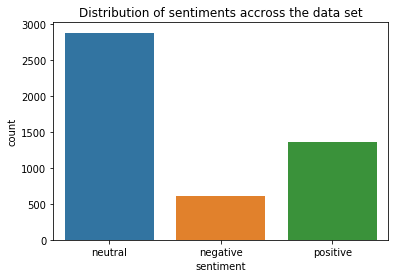

In [8]:
sns.countplot(x='sentiment', data=data).set_title("Distribution of sentiments accross the data set")
print(data.sentiment.value_counts()/data.shape[0])

## Feature Enginnering 

In [9]:
## Remove sentiment expression for the stop words
#stopwords.words("english")
#stopwords_to_keep = ['']

In [80]:
def tokenize(text,part_of_speech=False):
    '''
    Tokenize the text sentence
    Input:
        - text: (str): one financial review sentence
        - part_of_speech (Boolean): if true implement part of speech tagging and select the words you want to keep (["J","R","V"]) 
    Ouput:
    - clean_tokens (list): list of tokenized string text elements
    '''
    
    # Normalise by setting to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    
    # Create tokens 
    tokens = word_tokenize(text)
    
    # Remove stopwords
    tokens = [w for w in tokens if w not in stopwords.words("english")]
    #tokens = [w for w in tokens]
    
    # Part of speech tagging : https://pythonprogramming.net/part-of-speech-tagging-nltk-tutorial/
    if part_of_speech == True :
        all_words =[]
        pos = nltk.pos_tag(tokens)
        allowed_word_types = ["J","R","V","N"]
        for w in pos:
            if w[1][0] in allowed_word_types:
                all_words.append(w[0].lower())
        
    
    # Lemmatise words
    clean_tokens = [WordNetLemmatizer().lemmatize(w) for w in tokens]

    return clean_tokens

In [53]:
data["token_text"] = data["text"].apply(lambda x: tokenize(x))

In [54]:
data["token_text_pos"] = data["text"].apply(lambda x: tokenize(x,part_of_speech=True))

In [55]:
data.text.iloc[0]

'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .'

In [56]:
data.token_text.iloc[0]

['according',
 'gran',
 'company',
 'plan',
 'move',
 'production',
 'russia',
 'although',
 'company',
 'growing']

# II. Machine learning approach for sentiment classification

In [121]:
# Split train and test sets
x_train,x_test,y_train,y_test = train_test_split(data.text,data.sentiment,test_size = 0.2 , random_state = 0)

In [122]:
y_train[0:5]

667      neutral
1505     neutral
2696     neutral
1185    positive
3535     neutral
Name: sentiment, dtype: object

In [123]:
y_test[0:5]

2303    positive
2736     neutral
2790     neutral
2799     neutral
2554     neutral
Name: sentiment, dtype: object

# Split train and test sets
x_train,x_test,y_train_df,y_test_df = train_test_split(data.text,pd.get_dummies(data.sentiment.values),test_size = 0.2 , random_state = 0)

y_train = y_train_df.values
y_test = y_test_df.values

y_train_df[0:5]

y_train[0:5]

y_train_df.sum(axis=0)

In [124]:
# Check that the class are in same proportion in both train and test set
print(y_train.value_counts()/len(y_train))

print(y_test.value_counts()/len(y_test))

neutral     0.594427
positive    0.282766
negative    0.122807
Name: sentiment, dtype: float64
neutral     0.592784
positive    0.275258
negative    0.131959
Name: sentiment, dtype: float64


## Data Vizualisation

In [16]:
pos = x_train[y_train[y_train=='positive'].index]
pos[0:5]

1185    Atria will launch a campaign in September to p...
1888    `` We are pleased to welcome Tapeks Noma into ...
581     The contract was signed in August with Papua N...
12      A purchase agreement for 7,200 tons of gasolin...
2027    Loss after taxes amounted to EUR 1.2 mn compar...
Name: text, dtype: object

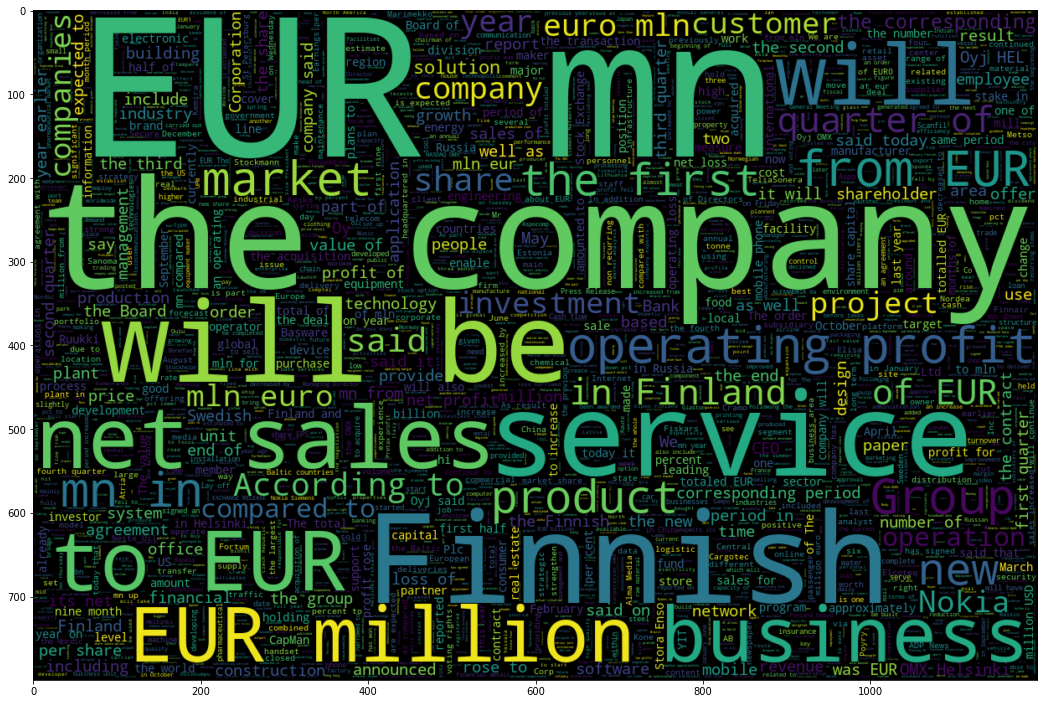

In [64]:
plt.figure(figsize = (18,24)) # Text Reviews with positive Ratings
wordcloud = WordCloud(min_font_size = 3,stopwords = STOPWORDS, max_words = 2500 , width = 1200 , height = 800).generate(" ".join(x_train))
plt.imshow(wordcloud,interpolation = 'bilinear')

## Standard Approach: using sklearn Tfidf transformer and a classification 

### - Baseline model

In [102]:
baseline = ["neutral"]*len(y_test)
y_pred_test = pd.Series(baseline)
y_pred_test

0      neutral
1      neutral
2      neutral
3      neutral
4      neutral
        ...   
965    neutral
966    neutral
967    neutral
968    neutral
969    neutral
Length: 970, dtype: object

In [103]:
# Print the classification report 
#print(classification_report(y_test, y_pred_test, target_names=["neutral","positive","negative"]))
print(classification_report(y_test, y_pred_test, labels=["neutral","positive","negative"]))

              precision    recall  f1-score   support

     neutral       0.59      1.00      0.74       575
    positive       0.00      0.00      0.00       267
    negative       0.00      0.00      0.00       128

    accuracy                           0.59       970
   macro avg       0.20      0.33      0.25       970
weighted avg       0.35      0.59      0.44       970



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### - Test different classification models

In [104]:
def make_prediction_with_pipeline(model):
    '''
    Take a model, build the associated pipeline and evaluate its performance on the test set
    Input: 
    - model (sklearn model) : model to be tested
    Output:
    - Confusion Matrix (array): matrix array with true and predicted labels
    - basic_pipeline (sklearn object): fitted pipeline object
    '''
    
    # Build the pipeline
    basic_pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', model)
    ])
    
    # Fit the pipeline
    basic_pipeline.fit(x_train,y_train)
    basic_start_time = time.time()
    basic_pipeline.fit(x_train,y_train)
    basic_end_time = time.time() - basic_start_time
    print("the training lasts for {} minutes".format(basic_end_time/60))
    
    # Make prediction
    y_pred_test = basic_pipeline.predict(x_test)
    
    # Print the classification report 
    print(classification_report(y_test, y_pred_test, labels=["neutral","positive","negative"]))
    
    # Plot the confusion matrix
    #disp = plot_confusion_matrix(basic_pipeline, x_test, y_test,display_labels=["neutral","positive","negative"],cmap=plt.cm.Blues)
    disp = plot_confusion_matrix(basic_pipeline, x_test, y_test,labels=["neutral","positive","negative"],cmap=plt.cm.Blues)
    disp.ax_.set_title("Confusion Matrix")
    print("Confusion Matrix")
    print(disp.confusion_matrix)
    
    return disp.confusion_matrix,basic_pipeline

the training lasts for 0.30971656640370687 minutes
              precision    recall  f1-score   support

     neutral       0.74      0.95      0.83       575
    positive       0.75      0.48      0.58       267
    negative       0.78      0.35      0.48       128

    accuracy                           0.74       970
   macro avg       0.76      0.60      0.63       970
weighted avg       0.75      0.74      0.72       970

Confusion Matrix
[[549  23   3]
 [129 128  10]
 [ 63  20  45]]


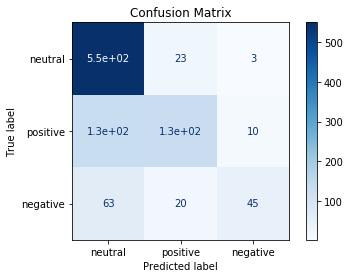

In [84]:
# Logistic regression
_, pipeline_fitted= make_prediction_with_pipeline(LogisticRegression(random_state=42))

the training lasts for 0.3375189661979675 minutes


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     neutral       0.69      0.98      0.81       575
    positive       0.65      0.36      0.46       267
    negative       0.00      0.00      0.00       128

    accuracy                           0.68       970
   macro avg       0.44      0.45      0.42       970
weighted avg       0.59      0.68      0.61       970

Confusion Matrix
[[564  11   0]
 [171  96   0]
 [ 87  41   0]]


(array([[564,  11,   0],
        [171,  96,   0],
        [ 87,  41,   0]]),
 Pipeline(memory=None,
          steps=[('vect',
                  CountVectorizer(analyzer='word', binary=False,
                                  decode_error='strict',
                                  dtype=<class 'numpy.int64'>, encoding='utf-8',
                                  input='content', lowercase=True, max_df=1.0,
                                  max_features=None, min_df=1,
                                  ngram_range=(1, 1), preprocessor=None,
                                  stop_words=None, strip_accents=None,
                                  token_pattern='(?u)\\b\\w\\w+\\b',
                                  tokenizer=<function tokenize at 0x1a4a7e6488>,
                                  vocabulary=None)),
                 ('tfidf',
                  TfidfTransformer(norm='l2', smooth_idf=True,
                                   sublinear_tf=False, use_idf=True)),
                 ('cl

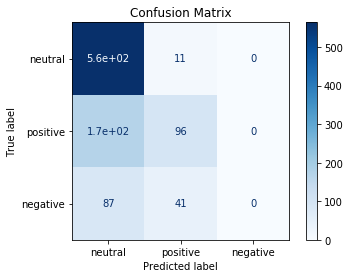

In [105]:
# Naive Bayes Classifier
make_prediction_with_pipeline(MultinomialNB())

the training lasts for 0.38081081708272296 minutes
              precision    recall  f1-score   support

     neutral       0.71      0.97      0.82       575
    positive       0.77      0.40      0.52       267
    negative       0.79      0.32      0.46       128

    accuracy                           0.73       970
   macro avg       0.76      0.56      0.60       970
weighted avg       0.74      0.73      0.69       970

Confusion Matrix
[[558  14   3]
 [153 106   8]
 [ 70  17  41]]


(array([[558,  14,   3],
        [153, 106,   8],
        [ 70,  17,  41]]),
 Pipeline(memory=None,
          steps=[('vect',
                  CountVectorizer(analyzer='word', binary=False,
                                  decode_error='strict',
                                  dtype=<class 'numpy.int64'>, encoding='utf-8',
                                  input='content', lowercase=True, max_df=1.0,
                                  max_features=None, min_df=1,
                                  ngram_range=(1, 1), preprocessor=None,
                                  stop_words=None, strip_accents=None,
                                  token_pattern='(?u)\\b\\w\\w+\\b',
                                  tokenizer=<function tokenize at...,
                                  vocabulary=None)),
                 ('tfidf',
                  TfidfTransformer(norm='l2', smooth_idf=True,
                                   sublinear_tf=False, use_idf=True)),
                 ('clf',
       

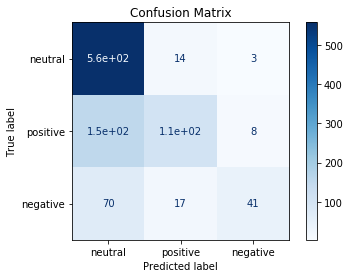

In [106]:
# Support Vector classifier
make_prediction_with_pipeline(SVC(random_state=42))

### - Try improving further one of the classification model

In [135]:
# Try to optimize the performance of the Logistic Regression model
pipeline_fitted.get_params()

{'memory': None,
 'steps': [('vect',
   CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                   dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                   lowercase=True, max_df=1.0, max_features=None, min_df=1,
                   ngram_range=(1, 1), preprocessor=None, stop_words=None,
                   strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                   tokenizer=<function tokenize at 0x1a22baaae8>, vocabulary=None)),
  ('tfidf',
   TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)),
  ('clf',
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                      intercept_scaling=1, l1_ratio=None, max_iter=100,
                      multi_class='auto', n_jobs=None, penalty='l2',
                      random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                      warm_start=False))],
 'verbose': False,
 'vect': CountVectorizer(analy

In [ ]:
parameters = {'clf__multi_class':['multinomial'],
             #'clf__class_weight': [None, "balanced"],
             'clf__C':np.random.uniform(1,10,4).tolist()}
skfolds = StratifiedKFold(n_splits=3)
gridsearch_pipeline = GridSearchCV(pipeline_fitted, param_grid=parameters, scoring='f1_samples', cv = skfolds)y

# Save the model
model_to_export
joblib.dump(model_to_export, "model.pkl")

# III. More advanced approach leveraging on Deep Learning, Embeddings and RNN

In [126]:
# Prepare output to implement a softmax classifier: one hot encoding
y_train_str = y_train
y_test_str = y_test
print(y_train_str)
print(y_test_str)

667      neutral
1505     neutral
2696     neutral
1185    positive
3535     neutral
          ...   
1033     neutral
3264     neutral
1653     neutral
2607     neutral
2732     neutral
Name: sentiment, Length: 3876, dtype: object
2303    positive
2736     neutral
2790     neutral
2799     neutral
2554     neutral
          ...   
2343     neutral
4841    negative
4693    negative
3534    negative
3353     neutral
Name: sentiment, Length: 970, dtype: object


In [127]:
y_train[y_train=='positive']=2
y_train[y_train=='neutral']=1
y_train[y_train=='negative']=0
y_test[y_test=='positive']=2
y_test[y_test=='neutral']=1
y_test[y_test=='negative']=0

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_train.shape, y_test.shape

((3876, 3), (970, 3))

In [130]:
print(y_train[0:5])

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [129]:
print(y_train_str)

667     1
1505    1
2696    1
1185    2
3535    1
       ..
1033    1
3264    1
1653    1
2607    1
2732    1
Name: sentiment, Length: 3876, dtype: object


## 1. Neural network with Keras

In [92]:
# Feature Engineering of training and test data
count_vec = CountVectorizer(max_features=4000, tokenizer=tokenize,max_df=0.9, min_df=0)
x_train_features = count_vec.fit_transform(x_train).todense()
x_test_features = count_vec.transform(x_test).todense()
x_train_features.shape,x_test_features.shape

((3876, 4000), (970, 4000))

In [93]:
tfidf = TfidfTransformer()
pd.DataFrame(tfidf.fit_transform(x_train_features).todense())

,0,1,2,3,4,5,6,7,8,9,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
0,0.000000,0.0,0.352811,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3871,0.135893,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3872,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3873,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3874,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [94]:
# Function to fit our model and plot accuracy curves for train and test data.

model = Sequential()
model.add(Dense(units=200, activation='relu', input_dim=x_train_features.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=3,activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

start_time = time.time()

history = model.fit(x_train_features, y_train, validation_data=(x_test_features, y_test), epochs=10, verbose=1)
end_time = time.time()-start_time
print(end_time)

#Print('Accuracy with',optimizer,'optimizer is :',model.evaluate(x_test_features, y_test)[1]*100)

Train on 3876 samples, validate on 970 samples
Epoch 1/10
3876/3876 [==============================] - 6s 1ms/sample - loss: 0.8764 - accuracy: 0.6146 - val_loss: 0.7163 - val_accuracy: 0.7000
Epoch 2/10
3876/3876 [==============================] - 3s 841us/sample - loss: 0.5209 - accuracy: 0.7980 - val_loss: 0.6009 - val_accuracy: 0.7546
Epoch 3/10
3876/3876 [==============================] - 3s 784us/sample - loss: 0.2685 - accuracy: 0.9053 - val_loss: 0.7067 - val_accuracy: 0.7423
Epoch 4/10
3876/3876 [==============================] - 3s 744us/sample - loss: 0.1441 - accuracy: 0.9574 - val_loss: 0.8037 - val_accuracy: 0.7443
Epoch 5/10
3876/3876 [==============================] - 3s 831us/sample - loss: 0.0768 - accuracy: 0.9788 - val_loss: 0.9532 - val_accuracy: 0.7371
Epoch 6/10
3876/3876 [==============================] - 3s 805us/sample - loss: 0.0627 - accuracy: 0.9840 - val_loss: 1.0369 - val_accuracy: 0.7423
Epoch 7/10
3876/3876 [==============================] - 3s 841us/sa

Text(0.5, 1.0, 'Adam Optimizer')

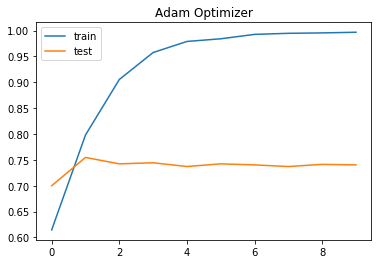

In [96]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.title('Adam Optimizer')

In [97]:
Y_pred = model.predict(x_test_features)
print(Y_pred.shape)
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred.shape)
print('Confusion Matrix')
print(confusion_matrix(np.argmax(y_test,axis=1), y_pred))
print(classification_report(np.argmax(y_test,axis=1), y_pred, target_names=["negative","neutral","positive"]))

(970, 3)
(970,)
Confusion Matrix
[[ 64  40  24]
 [ 17 493  65]
 [ 12  94 161]]
              precision    recall  f1-score   support

    negative       0.69      0.50      0.58       128
     neutral       0.79      0.86      0.82       575
    positive       0.64      0.60      0.62       267

    accuracy                           0.74       970
   macro avg       0.71      0.65      0.67       970
weighted avg       0.73      0.74      0.73       970



## 2. Add a pre-trained embedding layer using tensorflow hub

In [131]:
# Transform the data into tensors
X_train = tf.convert_to_tensor(x_train)
Y_train = tf.convert_to_tensor(y_train)
X_test = tf.convert_to_tensor(x_test)
Y_test = tf.convert_to_tensor(y_test)

In [132]:
import tensorflow_hub as hub

# Text embedding based on Swivel co-occurrence matrix factorization trained on English Google News 130GB corpus.
#embedding_1= "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
# https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1

# Word2Vec embedding trained on English Wikipedia corpus
embedding_2 = "https://tfhub.dev/google/Wiki-words-250-with-normalization/2"
# https://tfhub.dev/google/Wiki-words-500-with-normalization/2

hub_layer = hub.KerasLayer(embedding_2,input_shape=[],dtype=tf.string, trainable=False)

In [133]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/Wiki-words-250-with-normalization/2",
                           input_shape=[],dtype=tf.string, trainable=False)

In [134]:
embed_tensor = hub_layer(X_train[0:2])
print(embed_tensor.shape)
embed_tensor

(2, 250)


<tf.Tensor: id=17298, shape=(2, 250), dtype=float32, numpy=
array([[-1.52712166e-01, -1.36563748e-01,  6.17174804e-02,
        -1.79967463e-01,  9.57933441e-03,  1.34833604e-01,
         8.55822414e-02,  3.22328508e-02, -8.99228174e-03,
         9.56106260e-02, -1.42048433e-01,  2.43408918e-01,
        -1.07511349e-01, -8.88460726e-02,  2.72853911e-01,
         1.24718815e-01,  5.17277606e-02, -1.04414681e-02,
         3.20396312e-02,  1.19814828e-01,  4.25983267e-03,
         1.43762648e-01, -3.05806356e-03,  3.56078031e-03,
         2.82065004e-01, -2.22232006e-02,  1.21303812e-01,
         1.15962960e-01,  1.38368651e-01,  3.33463550e-02,
         1.86627641e-01, -2.51416191e-02,  4.01872918e-02,
        -1.18605852e-01, -8.18438176e-03,  1.11439086e-01,
        -2.04646766e-01, -9.77456346e-02,  2.94724733e-01,
        -1.13033086e-01, -2.16905713e-01,  2.29085043e-01,
        -1.07505610e-02, -4.68661226e-02,  1.74058601e-01,
         1.97038069e-01, -4.18239124e-02, -2.62974381e-

In [135]:
model = Sequential()
model.add(hub_layer)
model.add(Dense(16, activation='relu'))
model.add(Dense(3,activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, verbose=1)

Train on 3876 samples, validate on 970 samples
Epoch 1/20
3876/3876 [==============================] - 3s 702us/sample - loss: 0.9311 - accuracy: 0.5872 - val_loss: 0.8937 - val_accuracy: 0.5990
Epoch 2/20
3876/3876 [==============================] - 1s 275us/sample - loss: 0.8505 - accuracy: 0.6202 - val_loss: 0.8445 - val_accuracy: 0.6443
Epoch 3/20
3876/3876 [==============================] - 1s 311us/sample - loss: 0.8068 - accuracy: 0.6404 - val_loss: 0.8025 - val_accuracy: 0.6526
Epoch 4/20
3876/3876 [==============================] - 1s 277us/sample - loss: 0.7772 - accuracy: 0.6535 - val_loss: 0.7742 - val_accuracy: 0.6629
Epoch 5/20
3876/3876 [==============================] - 1s 281us/sample - loss: 0.7538 - accuracy: 0.6594 - val_loss: 0.7568 - val_accuracy: 0.6649
Epoch 6/20
3876/3876 [==============================] - 1s 279us/sample - loss: 0.7333 - accuracy: 0.6718 - val_loss: 0.7440 - val_accuracy: 0.6794
Epoch 7/20
3876/3876 [==============================] - 1s 290us/

Text(0.5, 1.0, 'Adam Optimizer')

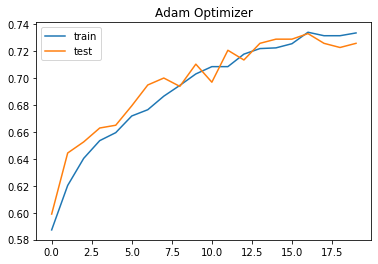

In [136]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.title('Adam Optimizer')

In [139]:
Y_pred = model.predict(X_test)
print(Y_pred.shape)
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred.shape)
print('Confusion Matrix')
print(confusion_matrix(np.argmax(y_test,axis=1), y_pred))
print(classification_report(np.argmax(y_test,axis=1), y_pred, target_names=["negative","neutral","positive"]))

(970, 3)
(970,)
Confusion Matrix
[[ 63  46  19]
 [ 23 501  51]
 [ 33  94 140]]
              precision    recall  f1-score   support

    negative       0.53      0.49      0.51       128
     neutral       0.78      0.87      0.82       575
    positive       0.67      0.52      0.59       267

    accuracy                           0.73       970
   macro avg       0.66      0.63      0.64       970
weighted avg       0.72      0.73      0.72       970



In [140]:
# Male prediction
print(x_test.iloc[0:5].values)
model.predict(x_test.iloc[0:5])

['The Bristol Port Company has sealed a one million pound contract with Cooper Specialised Handling to supply it with four 45-tonne , customised reach stackers from Konecranes .'
 'A paper mill in the central Maine town of Madison soon will have a new owner .'
 'ALEXANDRIA , Va. , Oct. 23 -- Hans-Otto Scheck of Espoo , Finland , has developed a method of identifying remote radio units in a communication system .'
 'Altona stated that the private company of Altona chairman Kevin Maloney , Tulla Resources , would take up its entitlement in full .'
 'Registration is required .']


array([[0.02683958, 0.29479152, 0.6783689 ],
       [0.0550314 , 0.89878094, 0.0461877 ],
       [0.02647229, 0.8875875 , 0.08594025],
       [0.10070144, 0.72458106, 0.17471752],
       [0.00868786, 0.968617  , 0.02269505]], dtype=float32)

## Results Analyses: recall that 0 is 'negative', 1 is 'neutral' and 2 is positive

### 1. Analyse the predicted values

In [173]:
# Build the predicted tabkes
Y_pred_df = pd.DataFrame(Y_pred,columns=["negative","neutral","positive"])
Y_pred_df["articles"] = x_test.values
Y_pred_df["token_text"] = Y_pred_df["articles"].apply(lambda x: tokenize(x))
Y_pred_df.head()

,negative,neutral,positive,articles,token_text
0,0.026840,0.294792,0.678369,The Bristol Port Company has sealed a one mill...,"[bristol, port, company, sealed, one, million,..."
1,0.055031,0.898781,0.046188,A paper mill in the central Maine town of Madi...,"[paper, mill, central, maine, town, madison, s..."
2,0.026472,0.887587,0.085940,"ALEXANDRIA , Va. , Oct. 23 -- Hans-Otto Scheck...","[alexandria, va, oct, 23, han, otto, scheck, e..."
3,0.100701,0.724581,0.174718,Altona stated that the private company of Alto...,"[altona, stated, private, company, altona, cha..."
4,0.008688,0.968617,0.022695,Registration is required .,"[registration, required]"


In [162]:
top_5_negative_headlines = Y_pred_df.sort_values(["negative"],ascending=False)
for i,v in top_5_negative_headlines[0:4].iterrows():
    print("--------------------------------------------------")
    print(v["articles"])
    print(" ")
    print("Negative score of {}".format(round(v["negative"],2)))

--------------------------------------------------
The airline estimated that the cancellation of its flights due to the closure of European airspace , and the process of recommencing traffic , have caused a the company a loss of EUR20m , including the costs of stranded passengers ' accommodation .
 
Negative score of 0.82
--------------------------------------------------
Most of the permanent layoffs will be in the plywood and sawn timber sectors of the Finnish company 's operations at several domestic mills , where earlier this year it temporarily laid off some 1,200 workers to save costs .
 
Negative score of 0.79
--------------------------------------------------
Last year 's third quarter result had been burdened by costs stemming from restructuring in the US .
 
Negative score of 0.74
--------------------------------------------------
In Q1 of 2009 , the company 's result before taxes from continuing operations , excluding non-recurring items , totalled EUR -0.4 mn , compared to

In [179]:
top_negative = Y_pred_df[Y_pred_df.negative>0.7].articles
top_negative

78     Last year 's third quarter result had been bur...
431    In Q1 of 2009 , the company 's result before t...
432    Operating result , excluding one-off items , t...
581    Approximately SEK 166 million in repayments ha...
647    Most of the permanent layoffs will be in the p...
955    The airline estimated that the cancellation of...
Name: articles, dtype: object

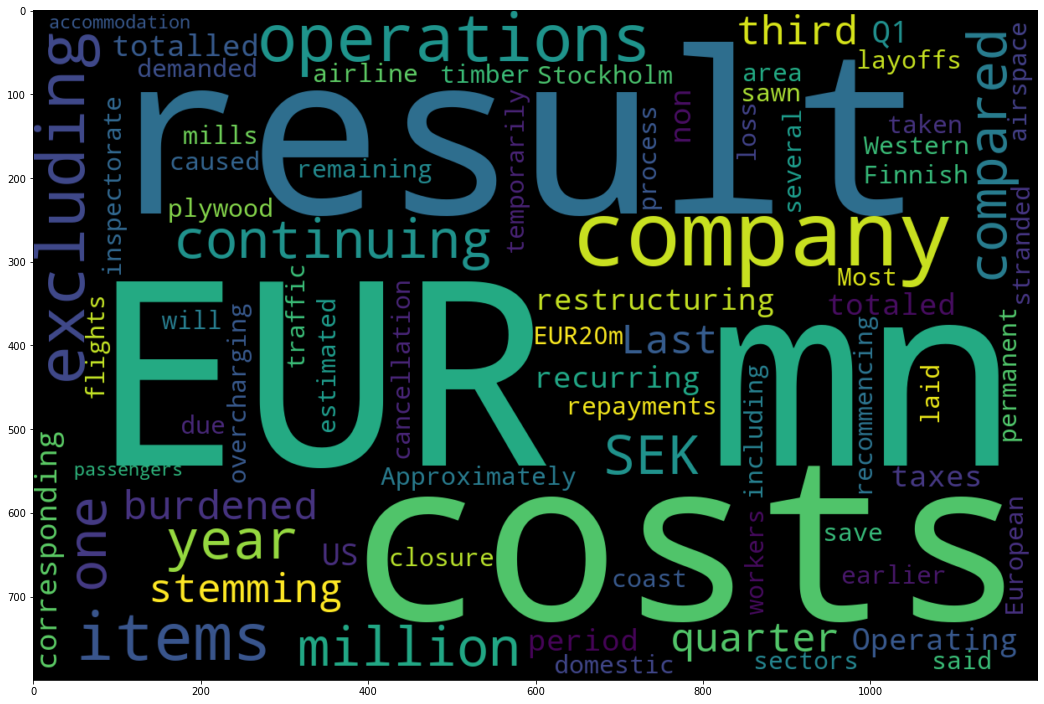

In [180]:
plt.figure(figsize = (18,24)) # Text Reviews with positive Ratings
wordcloud = WordCloud(min_font_size = 3,stopwords = STOPWORDS, max_words = 2500 , width = 1200 , height = 800).generate(" ".join(top_negative))
plt.imshow(wordcloud,interpolation = 'bilinear')

In [163]:
top_5_positive_headlines = Y_pred_df.sort_values(["positive"],ascending=False)
for i,v in top_5_positive_headlines[0:4].iterrows():
    print("--------------------------------------------------")
    print(v["articles"])
    print(" ")
    print("Positive score of {}".format(round(v["positive"],2)))

--------------------------------------------------
Having a China based operation will not only enable us to fully leverage our resources and expertise in wireless solutions , but also strengthen our capability to offer industry-leading products for our customers in China . ''
 
Positive score of 0.95
--------------------------------------------------
`` The Intel Atom processor has had tremendous success in the marketplace since its launch over 2 years ago , '' said Pankaj Kedia , director of global ecosystem programs for Intel Corp. 's Ultra Mobility Group .
 
Positive score of 0.93
--------------------------------------------------
The restructuring creates a more efficient organization with increased operational focus and stable profitability , and leads to more efficient production , said Bo Annvik , head of Specialty Stainless .
 
Positive score of 0.92
--------------------------------------------------
Ruukki 's delivery volumes and selling prices showed favourable development a

In [169]:
top_positive = Y_pred_df[Y_pred_df.positive>0.7].articles

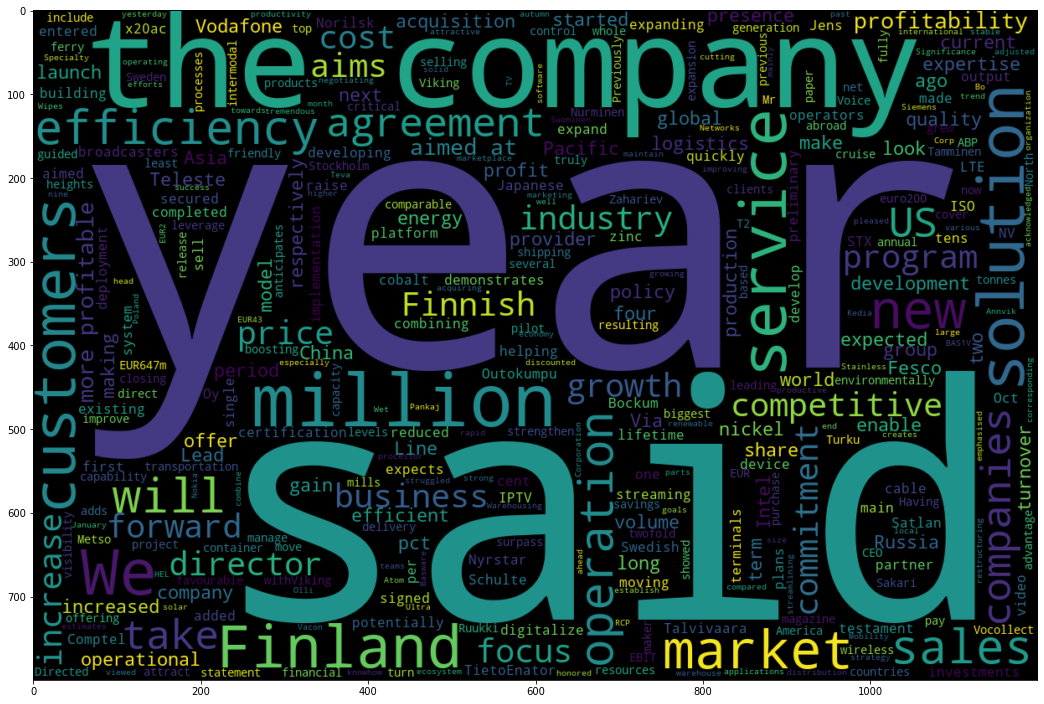

In [170]:
plt.figure(figsize = (18,24)) # Text Reviews with positive Ratings
wordcloud = WordCloud(min_font_size = 3,stopwords = STOPWORDS, max_words = 2500 , width = 1200 , height = 800).generate(" ".join(top_positive))
plt.imshow(wordcloud,interpolation = 'bilinear')

### Compare the predicted and true values

In [199]:
# Combine the predicted with the true tables
Y_true = pd.DataFrame(y_test,columns=["true_negative","true_neutral","true_positive"])
Y_pred_true = Y_pred_df.join(Y_true)

In [200]:
Y_pred_true.head()

,negative,neutral,positive,articles,token_text,true_negative,true_neutral,true_positive
0,0.026840,0.294792,0.678369,The Bristol Port Company has sealed a one mill...,"[bristol, port, company, sealed, one, million,...",0.0,0.0,1.0
1,0.055031,0.898781,0.046188,A paper mill in the central Maine town of Madi...,"[paper, mill, central, maine, town, madison, s...",0.0,1.0,0.0
2,0.026472,0.887587,0.085940,"ALEXANDRIA , Va. , Oct. 23 -- Hans-Otto Scheck...","[alexandria, va, oct, 23, han, otto, scheck, e...",0.0,1.0,0.0
3,0.100701,0.724581,0.174718,Altona stated that the private company of Alto...,"[altona, stated, private, company, altona, cha...",0.0,1.0,0.0
4,0.008688,0.968617,0.022695,Registration is required .,"[registration, required]",0.0,1.0,0.0


In [201]:
# Top error analyses for positive sentence
top_5_false_positive_headlines = Y_pred_true[Y_pred_true.true_positive==1].sort_values("negative",ascending=False)
for i,v in top_5_false_positive_headlines[0:4].iterrows():
    print("--------------------------------------------------")
    print(v["articles"])
    print(" ")
    print("Positive sentence with a predicted negative score of {}".format(round(v["negative"],2)))

--------------------------------------------------
The company reports a loss for the period of EUR 0.4 mn compared to a loss of EUR 1.9 mn in the corresponding period in 2005 .
 
Positive sentence with a predicted negative score of 0.68
--------------------------------------------------
By 14:29 CET on Monday , shares in Bavarian Nordic had climbed 1.21 % to DKK250 on the stock exchange in Copenhagen after having lost 7.41 % in the past month .
 
Positive sentence with a predicted negative score of 0.66
--------------------------------------------------
The loss for the third quarter of 2007 was EUR 0.3 mn smaller than the loss of the second quarter of 2007 .
 
Positive sentence with a predicted negative score of 0.66
--------------------------------------------------
Tiimari , the Finnish retailer , reported to have geenrated quarterly revenues totalling EUR 1.3 mn in the 4th quarter 2009 , up from EUR 0.3 mn loss in 2008 .
 
Positive sentence with a predicted negative score of 0.63


In [202]:
# Top error analyses for negative sentences
top_5_false_negatives_headlines = Y_pred_true[Y_pred_true.true_negative==1].sort_values("positive",ascending=False)
for i,v in top_5_false_negatives_headlines[0:4].iterrows():
    print("--------------------------------------------------")
    print(v["articles"])
    print(" ")
    print("Negative sentence with a predicted positive score of {}".format(round(v["positive"],2)))
    

--------------------------------------------------
Nokia Siemens Networks has struggled to make a profit in the past two years .
 
Negative sentence with a predicted positive score of 0.7
--------------------------------------------------
( ADP News ) - Feb 12 , 2009 - Finnish construction company Lemminkainen Oyj ( HEL : LEM1S ) said today its net profit decreased to EUR 63.5 million ( USD 81.1 m ) for 2008 from EUR 80.6 million for 2007 .
 
Negative sentence with a predicted positive score of 0.63
--------------------------------------------------
Finnish software and hardware developer Elektrobit Oyj HEL : EBG1V , or EB , said today it will temporarily lay off up to 200 people for a maximum of 90 day in Finland , aiming to achieve cost savings of EUR 1.7 million USD 2m in the second half of 2010 .
 
Negative sentence with a predicted positive score of 0.61
--------------------------------------------------
Sales at the Tiimari business went down by 8 % to EUR 11.8 million , while Ga

## 4. Combine LSTM with pre-trained Embeddings - WIP

<img src="LSTM.png" style="width:700px;height:400px;"> <br>
<caption><center> **Figure 1**: A 2-layer LSTM sentiment classifier. </center></caption>

In [118]:
maxLen = len(max(x_train, key=len).split())
print(maxLen)

81


In [119]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [121]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B/glove.6B.50d.txt')

In [177]:
# GRADED FUNCTION: sentences_to_indices

def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()`
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    
    ### START CODE HERE ###
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words = X[i].lower().split()
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            if w in word_to_index.keys():
                X_indices[i, j] = word_to_index[w]
            else:
                X_indices[i, j]=0
            # Increment j to j + 1
            j += 1
            
    ### END CODE HERE ###
    
    return X_indices

In [178]:
# GRADED FUNCTION: pretrained_embedding_layer

def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    ### START CODE HERE ###
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes, make it non-trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len, emb_dim, trainable = False)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [179]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)

In [185]:
sentence_indices = Input(maxLen, dtype = 'int32')

# Create the embedding layer pretrained with GloVe Vectors (≈1 line)
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)

# Propagate sentence_indices through your embedding layer, you get back the embeddings
embeddings = embedding_layer(sentence_indices)   

# Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
# Be careful, the returned output should be a batch of sequences.
X = LSTM(128, return_sequences = True)(embeddings)
# Add dropout with a probability of 0.5
X = Dropout(0.5)(X)
# Propagate X trough another LSTM layer with 128-dimensional hidden state
# Be careful, the returned output should be a single hidden state, not a batch of sequences.
X = LSTM(128, return_sequences = False)(X)
# Add dropout with a probability of 0.5
X = Dropout(0.5)(X)
# Propagate X through a Dense layer with softmax activation to get back a batch of 3-dimensional vectors.
X = Dense(3)(X)
# Add a softmax activation
X = Activation('softmax')(X)

# Create Model instance which converts sentence_indices into X.
model = Model(inputs = sentence_indices, outputs = X)

In [186]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 81)]              0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 81, 50)            20000050  
_________________________________________________________________
lstm_8 (LSTM)                (None, 81, 128)           91648     
_________________________________________________________________
dropout_18 (Dropout)         (None, 81, 128)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_19 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 3)                 387 

In [187]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [193]:
X_train_indices = sentences_to_indices(np.array(x_train), word_to_index, max_len = maxLen)

In [203]:
start_time = time.time()
history = model.fit(X_train_indices, Y_train, epochs = 50)
end_time = time.time()- start_time

Train on 3876 samples
Epoch 1/50
3876/3876 [==============================] - 85s 22ms/sample - loss: 0.8299 - accuracy: 0.6502
Epoch 2/50
3876/3876 [==============================] - 80s 21ms/sample - loss: 0.8804 - accuracy: 0.6249
Epoch 3/50
3876/3876 [==============================] - 81s 21ms/sample - loss: 0.8801 - accuracy: 0.6143
Epoch 4/50
3876/3876 [==============================] - 84s 22ms/sample - loss: 0.8760 - accuracy: 0.5952
Epoch 5/50
3876/3876 [==============================] - 79s 20ms/sample - loss: 0.8826 - accuracy: 0.6050
Epoch 6/50
3876/3876 [==============================] - 84s 22ms/sample - loss: 0.8524 - accuracy: 0.6388
Epoch 7/50
3876/3876 [==============================] - 69s 18ms/sample - loss: 0.8500 - accuracy: 0.6385
Epoch 8/50
3876/3876 [==============================] - 75s 19ms/sample - loss: 0.8492 - accuracy: 0.6380
Epoch 9/50
3876/3876 [==============================] - 69s 18ms/sample - loss: 0.8482 - accuracy: 0.6404
Epoch 10/50
3876/3876 [=

In [206]:
end_time/60

63.440104417006175

Text(0.5, 1.0, 'Adam Optimizer')

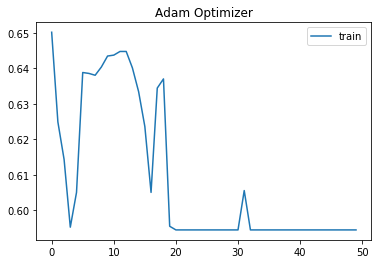

In [208]:
plt.plot(history.history['accuracy'], label='train')
#plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.title('Adam Optimizer')

In [195]:
Y_pred = model.predict(X_train_indices)

In [197]:
y_pred = np.argmax(Y_pred, axis=1)
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [199]:
print('Confusion Matrix')
print(confusion_matrix(np.argmax(y_train,axis=1), y_pred))

Confusion Matrix
[[   0  155  321]
 [   0 2226   78]
 [   0  722  374]]


In [202]:
print(classification_report(np.argmax(y_train,axis=1), y_pred, target_names=["negative","neutral","positive"]))

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       476
     neutral       0.72      0.97      0.82      2304
    positive       0.48      0.34      0.40      1096

    accuracy                           0.67      3876
   macro avg       0.40      0.44      0.41      3876
weighted avg       0.56      0.67      0.60      3876



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
